# Grouping Artists by Lyrics (*In the Rock Genre*)

### NOTE: The content below contains explicit language.
*To view the word cloud results, scroll directly to the end.

We can clearly see that the vectorizer and clustering methods were able to successfully organize the rock artists. Each of the three clusters have word types that are more popular than others. The three focuses appear to be: swearing/explicit language, holiday/happy lyrics, and gospel/religion based words.

Examples of words from each cluster:<br>
**Swearing/Explicit:** Fuck, shit, bitch, stupid, suck, sex, etc.<br>
**Holiday/Happy:** Christmas, santa, wonderful, rainbow, lovely, etc.<br>
**Gospel/Religion:** Bye, mercy, come on, shall, suffer, souls, praise, etc.

Examples of artists from each cluster:<br>
*Swearing/Explicit:* Arctic Monkeys, Blink 182, Disturbed, Foo Fighters, Godsmack<br>
*Holiday/Happy:* Alabama, Bob-Dylan, Chris Isaak, Elvis Presley<br>
*Gospel/Religion:* Arcade Fire, Coldplay, Dave Matthews, Fall-Out-Boy, The Black Keys

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import seaborn as sns
import re
import random
from time import time
from wordcloud import WordCloud
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from __future__ import unicode_literals
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
# import nltk
# nltk.download()
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [3]:
# import csv
lyrics = pd.read_csv('lyrics.csv')

In [4]:
# drop missing data and songs without genre
lyrics = lyrics.dropna()
lyrics = lyrics[lyrics.genre.str.contains("Not Available") == False]
lyrics = lyrics[lyrics.genre.str.contains("Other") == False]

# keep Rock genre only
lyrics = lyrics[lyrics.genre == 'Rock']

# drop unexistent or artists that don't make sense
lyrics = lyrics[lyrics.artist != 'aeena']
lyrics = lyrics[lyrics.artist != 'adaaeaaineay-iaidiia']
lyrics = lyrics[lyrics.artist != 'girls-generation']
lyrics = lyrics[lyrics.artist != 'edaiaoidee']

In [5]:
lyrics.nunique()

index     108700
song       84762
year          48
artist      3761
genre          1
lyrics    102003
dtype: int64

In [6]:
# lowercase everything
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics['song'] = lyrics['song'].str.lower()
lyrics['artist'] = lyrics['artist'].str.lower()
 
# attempt to drop foreign language songs
searchfor = [' tu ', ' und ', ' ein ', ' dich ', ' amor ', ' ich ', ' auf ', ' bin ', ' dich ', ' du ', ' nicht ', ' el ']
lyrics = lyrics[~lyrics.lyrics.str.contains('|'.join(searchfor))]

In [7]:
# only keep artists with at least 100 songs
lyrics = lyrics.groupby("artist").filter(lambda x: len(x) > 99)

# take a sample of 100 songs from each artist
grouped = lyrics.groupby('artist')
lyrics = grouped.apply(lambda x: x.sample(n=100))

In [8]:
lyrics.nunique()

index     23500
song      21295
year         47
artist      235
genre         1
lyrics    22261
dtype: int64

In [9]:
'''# take a sample of 100 artist
artist_list = lyrics.artist.unique()
artist_list = artist_list[random.sample(range(235), 100)]

# make sure the number of artists is correct
len(artist_list)''';

In [10]:
'''# apply our 100 artist sample to our dataframe
lyrics = lyrics[lyrics['artist'].isin(artist_list)]''';

In [11]:
# combine song name and lyrics
lyrics['lyrics'] = lyrics['lyrics'] + lyrics['song']

# remove all apotrophes
lyrics['lyrics'] = lyrics['lyrics'].str.replace("'", "")

In [12]:
lyrics_original = lyrics
lyrics.head()

index                song  year artist genre  \
artist                                                         
10-cc  238091  238091     deadlock-melody  2006  10-cc  Rock   
       238104  238104     old-mister-time  2006  10-cc  Rock   
       238134  238134  don-t-turn-me-away  2006  10-cc  Rock   
       238080  238080       brand-new-day  1975  10-cc  Rock   
       238207  238207          oh-effendi  2008  10-cc  Rock   

                                                          lyrics  
artist                                                            
10-cc  238091  i was walkin down the street\nconcentratin on ...  
       238104  he looked funny\nthe children called him the s...  
       238134  you and i dont have to hurry\ntake your time n...  
       238080  when you open your eyes\nto a brand new mornin...  
       238207  in the middle of a caravan\non a four wheel dr...

In [13]:
# combine all lyrics for each artist
lyrics = lyrics.groupby('artist').lyrics.apply(lambda x: x.sum())

c:\users\todd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'artist' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [14]:
# clean some text
def text_clean(text):
    text = text.replace("\n"," ").replace(","," ").replace("in' ",'ing ').replace("i've","i have").replace("'cos","bacause").replace("'s", " is")
    text = text.replace("'re" ," are").replace(",","").replace("'d"," would").replace("n't"," not").replace("i'm","i am").replace("dont","do not")
    text = text.replace("'ll"," will").replace("!"," ").replace("-"," ").replace('"',"").replace(")","").replace("(","").replace("'","")
    text = text.replace("[","").replace("]","").replace("?","").replace(" x ","").replace("%","").replace("#","").replace("ya","yes").replace("darlin","darling")
    text = text.replace("0","").replace("1","").replace("2","").replace("3","").replace("4","").replace("5","").replace("6","").replace("7","").replace("8","").replace("9","")
    return text

lyrics = text_clean(lyrics)

lyrics = lyrics.str.replace('in ', 'ing ')
lyrics = lyrics.str.replace(' ing ', 'in')

In [15]:
# set stemmer
stemmer = SnowballStemmer('english')

# define a function that accepts text and returns a list of lemmas or stems
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize(pos='v') for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
# create and fit our vectorizer
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 1/2 of texts
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case
                             norm=u'l2', # longer paragraphs and shorter paragraphs treated equally
                             smooth_idf=True, # add 1 to all document frequencies
                             max_features=125, # limit to top 100 words
                             analyzer=lambda x:word_tokenize(x, how='lemma')
                        )
vect = tfidf.fit_transform(lyrics)

In [16]:
# preserve column names
vocab = tfidf.vocabulary_
tfidf = tfidf.transform(lyrics)

# be sure keys are sorted
tfidf = pd.DataFrame(tfidf.toarray(), columns=sorted(vocab.keys()))

In [17]:
# see our result
tfidf.head()

,2,action,american,anybody,ass,ba,bang,battle,bill,bitch,...,vocals,wa,west,whoa,wo,wonderful,x2,yea,yo,york
0,0.000000,0.153372,0.243328,0.000000,0.083840,0.0,0.042665,0.000000,0.037538,0.040055,...,0.000000,0.0,0.000000,0.000000,0.0,0.077099,0.000000,0.068921,0.000000,0.000000
1,0.041123,0.031670,0.000000,0.000000,0.069249,0.0,0.035240,0.050088,0.010335,0.066168,...,0.000000,0.0,0.009668,0.603403,0.0,0.000000,0.050346,0.012650,0.233309,0.033645
2,0.000000,0.021824,0.025181,0.006903,0.031814,0.0,0.024284,0.000000,0.007122,0.030398,...,0.015657,0.0,0.000000,0.028191,0.0,0.000000,0.013878,0.017435,0.000000,0.208670
3,0.000000,0.101796,0.029364,0.024149,0.083470,0.0,0.000000,0.048299,0.000000,0.319020,...,0.000000,0.0,0.000000,0.000000,0.0,0.127930,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.187121,0.000000,0.000000,0.000000,0.0,0.037857,0.000000,0.000000,0.071081,...,0.000000,0.0,0.046739,0.000000,0.0,0.239436,0.000000,0.061154,0.221149,0.018072


In [18]:
'''# create extra feature, length
length = (lyrics_original.groupby('artist')['lyrics']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='mean_len_text'))
tfidf = tfidf.join(length)''';

In [19]:
# remove columns that have two characters or less
remove = tfidf.columns.str.findall('\w{3,}').str.join(' ')
remove = pd.DataFrame(remove, columns =['columns'])
remove = remove[remove['columns'] != '']
tfidf = tfidf[remove['columns']]

In [20]:
pd.set_option('display.max_rows', 500)
tfidf.nunique()

action        101
american       76
anybody       111
ass            85
bang           82
battle        111
bill          105
bitch          93
bomb          107
bottom        116
bow           110
box           116
breeze        115
bye            90
cars          118
case          117
christmas     112
church        104
cmon           74
comfort       107
curse         113
darlin         61
doctor        118
dollar        109
doo            30
drug           99
drum          110
dumb           88
fallinlove     87
fame           99
folks         106
food          104
force         118
fuck          117
garden        101
gim            64
glow          117
gods          103
grey          108
heavens       106
huh            70
hurry         114
inthe         118
jack          107
jam            88
joe            60
john           89
johnny         71
kimi            4
kinda         101
law           101
lovely        110
melt          116
mercy         111
mighty        100
mom       

In [21]:
# drop nonsense columns
tfidf.drop(columns = ['doo', 'gim', 'inthe', 'jack', 'joe', 'john', 'johnny', 'mary', 'instrumental', 'kimi', 'pum', 'theyd', 'therell', 'whoa', 'yea', 'x2'], inplace=True, errors='ignore')

# fix names
tfidf = tfidf.rename(columns = {'mountaing':'mountain'})
tfidf = tfidf.rename(columns = {'york':'new york'})
tfidf = tfidf.rename(columns = {'nothings':'nothing'})

In [22]:
tfidf.nunique()

action        101
american       76
anybody       111
ass            85
bang           82
battle        111
bill          105
bitch          93
bomb          107
bottom        116
bow           110
box           116
breeze        115
bye            90
cars          118
case          117
christmas     112
church        104
cmon           74
comfort       107
curse         113
darlin         61
doctor        118
dollar        109
drug           99
drum          110
dumb           88
fallinlove     87
fame           99
folks         106
food          104
force         118
fuck          117
garden        101
glow          117
gods          103
grey          108
heavens       106
huh            70
hurry         114
jam            88
kinda         101
law           101
lovely        110
melt          116
mercy         111
mighty        100
mom            83
mountain      113
mystery       114
noise         115
nose          114
nothing       116
older         113
outta          96
paradise  

In [23]:
# store for cluster
cluster = tfidf

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=200)
minibatchkmeans.fit(cluster)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(cluster)

# join our cluster number to each row/artist
predict_mini = pd.DataFrame(predict_mini, columns=['cluster'])
tfidf = tfidf.join(predict_mini)

In [24]:
# check how different clusters are
tfidf.groupby('cluster').mean()

,action,american,anybody,ass,bang,battle,bill,bitch,bomb,bottom,...,suck,suffer,sugar,sunshine,surrender,vision,vocals,west,wonderful,new york
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.023913,0.019717,0.026757,0.076811,0.034880,0.022094,0.029258,0.093572,0.035769,0.039230,...,0.103064,0.053039,0.015760,0.018321,0.026012,0.044939,0.010616,0.017522,0.019555,0.012064
1,0.025276,0.034551,0.031546,0.003042,0.024521,0.008689,0.012848,0.005793,0.008242,0.030756,...,0.003466,0.016872,0.033531,0.030662,0.014448,0.012028,0.001873,0.039440,0.112460,0.026491
2,0.034427,0.033143,0.036614,0.016461,0.030261,0.041852,0.026124,0.021297,0.033109,0.036183,...,0.024898,0.041378,0.031577,0.032426,0.036633,0.034097,0.015802,0.033116,0.036409,0.038242


In [25]:
# make an artist column
tfidf['artist'] = lyrics.index

In [26]:
# create lists of artist from each cluster
one_list = tfidf.artist[tfidf.cluster == 0]
two_list = tfidf.artist[tfidf.cluster == 1]
three_list = tfidf.artist[tfidf.cluster == 2]
four_list = tfidf.artist[tfidf.cluster == 3]
five_list = tfidf.artist[tfidf.cluster == 4]

In [27]:
# create dataframes for each cluster
cluster_one = tfidf[tfidf['artist'].isin(one_list)]
cluster_two = tfidf[tfidf['artist'].isin(two_list)]
cluster_three = tfidf[tfidf['artist'].isin(three_list)]
cluster_four = tfidf[tfidf['artist'].isin(four_list)]
cluster_five = tfidf[tfidf['artist'].isin(five_list)]

In [28]:
# drop cluster number and artist name
cluster_one_totals = cluster_one.drop(columns=['cluster', 'artist'])
cluster_two_totals = cluster_two.drop(columns=['cluster', 'artist'])
cluster_three_totals = cluster_three.drop(columns=['cluster', 'artist'])
cluster_four_totals = cluster_four.drop(columns=['cluster', 'artist'])
cluster_five_totals = cluster_five.drop(columns=['cluster', 'artist'])

In [29]:
# add together the results for each cluster
cluster_one_totals = cluster_one_totals.sum()
cluster_two_totals = cluster_two_totals.sum()
cluster_three_totals = cluster_three_totals.sum()
cluster_four_totals = cluster_four_totals.sum()
cluster_five_totals = cluster_five_totals.sum()

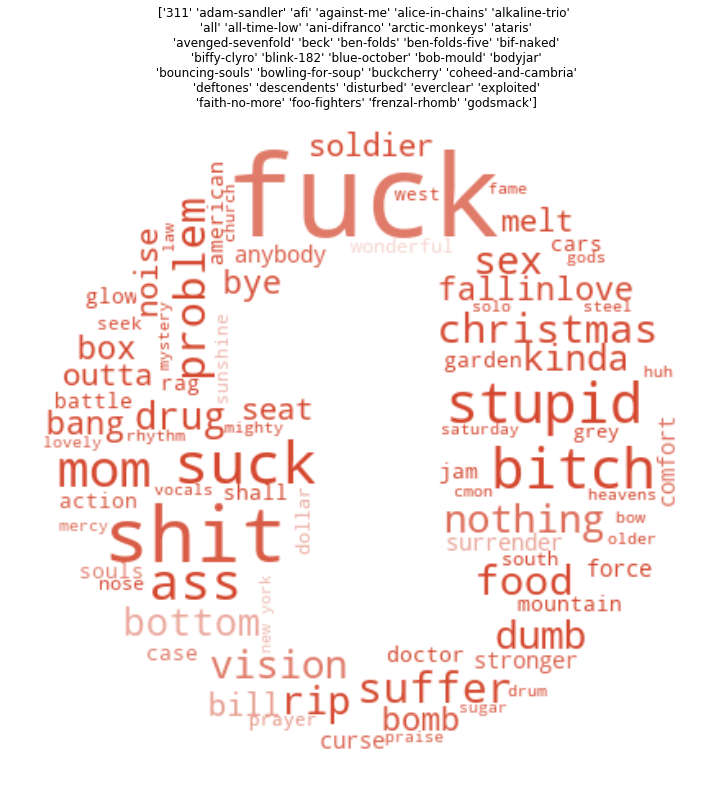

<Figure size 432x288 with 0 Axes>

In [30]:
# create word cloud for cluster one
d = path.dirname('__file__')
mask = np.array(Image.open(path.join(d, "one.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_one = WordCloud().fit_words(cluster_one_totals)

first = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_one_totals)

plt.figure(figsize=(12,12))
plt.title(one_list.unique(), fontsize=12)
plt.imshow(first.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

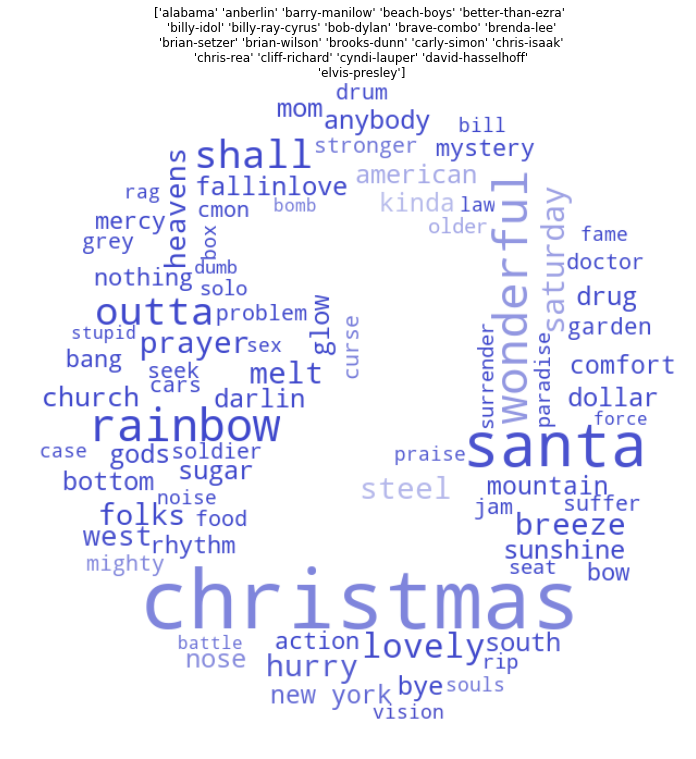

<Figure size 432x288 with 0 Axes>

In [31]:
# create word cloud for cluster two
mask = np.array(Image.open(path.join(d, "two.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_two = WordCloud().fit_words(cluster_two_totals)

second = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_two_totals)

plt.figure(figsize=(12,12))
plt.title(two_list.unique(), fontsize=12)
plt.imshow(second.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

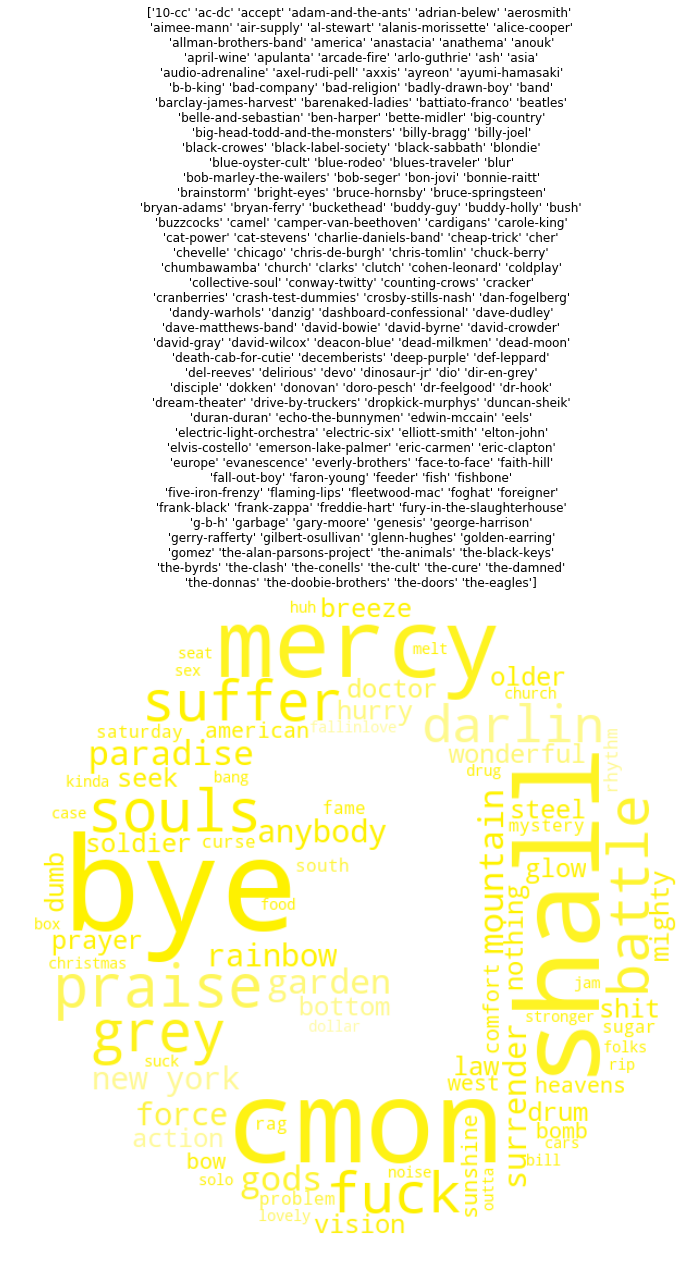

<Figure size 432x288 with 0 Axes>

In [32]:
# create word cloud for cluster three
mask = np.array(Image.open(path.join(d, "three.png")))
image_colors = ImageColorGenerator(mask)

wordcloud_three = WordCloud().fit_words(cluster_three_totals)

third = WordCloud(background_color="white", width=800, height=800, max_words=80, 
                  mask=mask, max_font_size=120, random_state=50).fit_words(cluster_three_totals)

plt.figure(figsize=(12,12))
plt.title(three_list.unique(), fontsize=12)
plt.imshow(third.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()